In [ ]:
# !pip install SimpleITK
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import SimpleITK as sitk


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [26]:
seg_p="/kaggle/input/penguin/PENGWIN_labels/002.mha"
im_p ="/kaggle/input/penguin/PENGWIN_images/002.mha"

seg = sitk.ReadImage(seg_p, sitk.sitkInt16)
im = sitk.ReadImage(im_p, sitk.sitkInt16)

seg_a = sitk.GetArrayFromImage(seg)
im_a = sitk.GetArrayFromImage(im)

seg_tensor = torch.from_numpy(seg_a).to(device)
im_tensor=torch.from_numpy(im_a).to(device)

seg_tensor = seg_tensor[:,289:290,:].permute(1,0,2)
im_tensor  =  im_tensor[:,289:290,:].permute(1,0,2)

 
img_slices = torch.stack([pad_torch(normalize_slice(img_slice), 512, 512) for img_slice in im_tensor]) 

initial_shapes=  (seg_tensor.shape[1] , seg_tensor.shape[2])

img_slices = img_slices.unsqueeze(1).float()  

print(seg_tensor.shape , img_slices.shape)


torch.Size([1, 265, 512]) torch.Size([1, 1, 512, 512])


(array([ 0,  1, 21], dtype=int16), array([129064,   2802,   3814]))


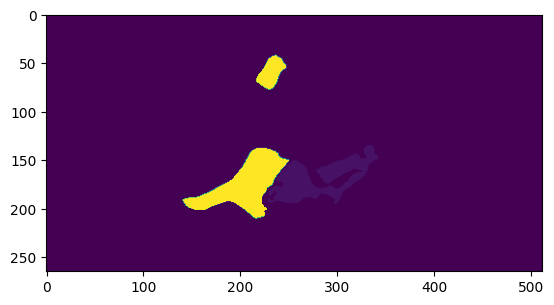

In [27]:
label=seg_tensor[0,:,:].detach().cpu()
plt.imshow(label)
print(np.unique(label , return_counts=True))

In [28]:
import os

weights="/kaggle/working/epoch350-loss0.5407.pth"
print(f"File size: {os.path.getsize(weights) if os.path.exists(weights) else 'N/A'}")


model = UNet(in_channels=1, out_channels=30).to(device)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(weights))

out = model(img_slices)
print(out.shape)

File size: 124271474
torch.Size([1, 30, 512, 512])


In [29]:
predicted_mask = torch.argmax(out, dim=1)
print(predicted_mask.shape)

reshaped_slices=torch.stack([unpad(img_slice,initial_shapes[0] ,initial_shapes[1] ) for img_slice in predicted_mask]) 

torch.Size([1, 512, 512])


In [30]:
print(reshaped_slices.shape)

torch.Size([1, 265, 512])


torch.Size([265, 512])
(array([ 0,  1,  2, 13, 21, 22, 23, 24]), array([128945,   2399,    167,    123,   3656,      3,    381,      6]))


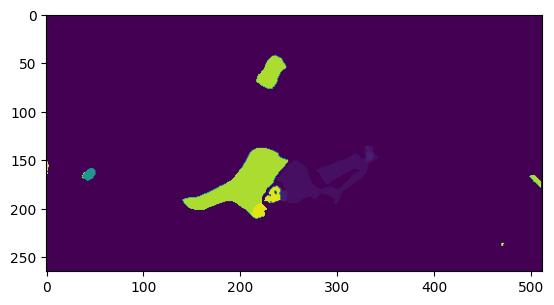

In [31]:
two=reshaped_slices[0,:,:].detach().cpu()
print(two.shape)
plt.imshow(two)
print(np.unique(two,return_counts=True) )


torch.Size([512, 512])
(array([ 0,  1, 11, 12, 13, 21]), array([250450,   4167,   1518,     31,   1234,   4744]))


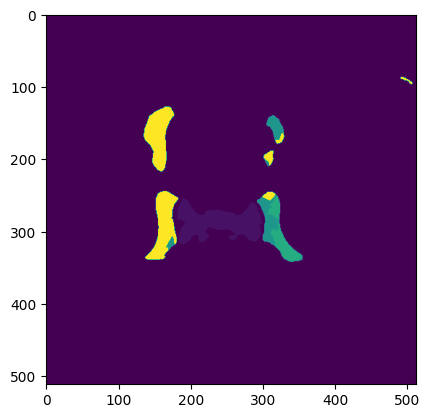

In [25]:
one=predicted_mask[0,:,:].detach().cpu()
print(one.shape)
print(np.unique(one,return_counts=True) )
plt.imshow(one)

In [ ]:
# probs = F.softmax(out, dim=1)
# max_index = torch.argmax(probs, dim=1)
# result = torch.gather(out, 1, max_index.unsqueeze(1)).float()
# print(result.shape)

In [4]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=30):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        def upconv_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = upconv_block(1024, 512)
        self.decoder4 = conv_block(1024, 512)
        
        self.upconv3 = upconv_block(512, 256)
        self.decoder3 = conv_block(512, 256)
        
        self.upconv2 = upconv_block(256, 128)
        self.decoder2 = conv_block(256, 128)
        
        self.upconv1 = upconv_block(128, 64)
        self.decoder1 = conv_block(128, 64)
        
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.encoder3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.encoder4(F.max_pool2d(enc3, kernel_size=2, stride=2))
        
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2, stride=2))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        output = self.output_conv(dec1)
        return output


In [6]:
def unpad(x , a,b):
    r,c=np.shape(x)
    start=(r-a)//2
    end=(c-b)//2
    return x[ start: start+a , end:end+b]
def pad_torch(x, a, b):
    r, c = x.shape  # Get the last two dimensions
    temp = torch.zeros((a, b), device=x.device)
    r_start = (a - r) // 2
    c_start = (b - c) // 2
    temp[r_start:r_start+r, c_start:c_start+c] = x
    return temp
def percentage(mask):
    return (np.sum(mask > 0) / mask.size) * 100


In [7]:
def epochnum(file):
    try:
        epoch_part = file.split('epoch')[1].split('-')[0]
        return int(epoch_part)
    except (IndexError, ValueError):
        return -1


In [8]:
def normalize_slice(slice, min_val=-350, max_val=350):
    slice_clamped = torch.clamp(slice, min=min_val, max=max_val)
    
    slice_normalized = (slice_clamped - min_val) / (max_val - min_val)
    
    return slice_normalized * (max_val - min_val) + min_val


In [1]:
class PenguinDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_list = sorted(os.listdir(self.image_dir))[1:2]
        self.mask_list = sorted(os.listdir(self.mask_dir))[1:2]
        
    def __getitem__(self, index):
        
        img_path = os.path.join(self.image_dir, self.image_list[index])
        mask_path = os.path.join(self.mask_dir, self.mask_list[index])
        
        image = sitk.ReadImage(img_path, sitk.sitkInt16)
        mask = sitk.ReadImage(mask_path, sitk.sitkInt16)       
        
        img = sitk.GetArrayFromImage(image)
        ms = sitk.GetArrayFromImage(mask)
  
        img_tensor = torch.from_numpy(img).to(device)
        mask_tensor = torch.from_numpy(ms).to(device)
        
        return img_tensor, mask_tensor

    def __len__(self):
        return len(self.image_list)

In [6]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

penguin_data = PenguinDataset("/kaggle/input/penguin/PENGWIN_images", "/kaggle/input/penguin/PENGWIN_labels")
penguin_dataloader = DataLoader(penguin_data, batch_size=1, shuffle=True)

model = UNet(in_channels=1, out_channels=30).to(device)
model = nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()

optim = torch.optim.Adam(model.parameters(), lr=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.2, patience=2, verbose=True)


In [7]:
def train_coronal(model, optim, criterion, dataloader, epochs, device, start_epoch, num_slices, tol):
    for epoch in range(start_epoch + 1, start_epoch + epochs + 1):
        epoch_loss = 0.0
        num_examples = 0
        c=0
        for img, msk in dataloader:
            volume_loss = 0
            num = img.shape[2]  # Changed to shape[2] for coronal
            l = []
            start, end = None, None
            
            for i in range(num):
                t = msk[:,:,i,:]  # Changed indexing for coronal
                l.append(percentage(np.array(t.cpu()).squeeze(0)))
            for i in range(len(l)-1):
                if l[i+1] > 0:
                    start = i+1
                    break
            for j in range(len(l)):
                if l[-j-1] > 0:
                    end = len(l)-j-1
                    break
            
            for i in range(start-tol, end+tol, num_slices):
                image = img[:, :, i:i+num_slices, :] 
                mask = msk[:, :, i:i+num_slices, :]
                
                final_images = torch.stack([ pad_torch(normalize_slice(img_slice), 512, 512)  for img_slice in image.squeeze(0).permute(1,0,2)])

                final_masks = torch.stack([pad_torch(msk_slice, 512, 512) for msk_slice in mask.squeeze(0).permute(1,0,2)])
                
                final_images = final_images.unsqueeze(1).float()
                final_masks= final_masks.long()
                
                out = model(final_images)
    
                loss = criterion(out, final_masks)

                volume_loss += loss.item()
                optim.zero_grad()
                loss.backward()
                optim.step()
                c+=num_slices
                
                
            epoch_loss += volume_loss 
        scheduler.step(epoch_loss)

            
        print(f"epoch {epoch}, loss {epoch_loss:.4f}, mean_loss {epoch_loss/c:.4f}")
        
        if epoch % 5 == 0:
            model_filename = f"epoch{epoch}-loss{epoch_loss:.4f}.pth"
            model_path = os.path.join("/kaggle/working", model_filename)
            torch.save(model.state_dict(), model_path)
            print(f"Model saved: {model_path}")

In [8]:
path = "/kaggle/working"
pth_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.endswith('.pth')]
pth_files.sort(key=lambda x: epochnum(os.path.join(path, x)) , reverse=True)
# print(pth_files)
if len(pth_files)>0:
    state= pth_files[0]
else:
    state=None

if state:
    weights = os.path.join(path, state)
    print(f"Resuming from checkpoint: {state}")
    print(f"Loading weights from: {state}")
    model.load_state_dict(torch.load(weights))
    start_epoch = epochnum(state)
else:
    print("No checkpoint found. Starting from scratch.")
    start_epoch = 0

print(f"Starting from epoch: {start_epoch}")

epochs=70
num_slices=14
train_coronal(model, optim, criterion, penguin_dataloader, epochs=epochs, device=device, start_epoch=start_epoch , num_slices=num_slices , tol=-5)

Resuming from checkpoint: epoch465-loss0.0175.pth
Loading weights from: epoch465-loss0.0175.pth
Starting from epoch: 465


OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 85, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_35/2312664748.py", line 41, in forward
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 215, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py", line 460, in forward
    return self._conv_forward(input, self.weight, self.bias)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py", line 456, in _conv_forward
    return F.conv2d(input, weight, bias, self.stride,
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB. GPU 0 has a total capacty of 14.74 GiB of which 20.12 MiB is free. Process 3169 has 14.72 GiB memory in use. Of the allocated memory 14.17 GiB is allocated by PyTorch, and 354.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


In [ ]:
path = "/kaggle/working"
pth_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.endswith('.pth')]
pth_files.sort(key=lambda x: epochnum(os.path.join(path, x)) , reverse=True)
for file in pth_files[1:]:
# #     if file=="state.db":
    os.remove(os.path.join(path , file))
    print(f"removed {file}")
print(pth_files[0])

In [5]:
print(os.listdir(path))

['.virtual_documents', 'epoch465-loss0.0175.pth', 'state.db']


In [15]:
!nvidia-smi
# !nvidia-smi --gpu-reset

Tue Aug  6 15:30:09 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P0             29W /   70W |   14489MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# device = cuda.get_current_device()
# print(device)
# device.reset()